In [325]:
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import pygame

CustomerStatus = Enum("CustomerStatus", ["no_taxi", "waiting", "inside", "end"])
TaxiStatus = Enum("CustomerStatus", ["going_to_customer", "has_customer", "free", "stopped"])

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [228]:
INITIAL_FEE = 5
LENGTH_FEE = 2

In [229]:
class Taxi:
    def __init__(self, current_vertex):
        self.status = "free"
        self.total_income = 0
        self.total_distance = 0
        self.current_vertex = current_vertex
        self.n_customers = 0
        # self.timer = 0  we can add time counter and increment in make 

In [230]:
class Customer:
    def __init__(self, current_vertex, destination_vertex):
        self.status: CustomerStatus = "no_taxi"
        self.current_vertex = current_vertex
        self.destination_path = None
        self.destination_vertex = destination_vertex
        self.assigned_taxi = None
        self.pickup_path = None

In [321]:
class TaxiService:
    def __init__(self, graph):
        self.customers: list[Customer] = []
        self.graph = graph
        
        self.taxis: dict[str, Taxi] = {}
        self.taxis_in_vertices = {k: [] for k in graph.keys()}  # all vertices with current taxis, need to check if there are free taxis
        self.customers_in_vertices = {k: [] for k in graph.keys()}
        
        for i in range(5):
            self.generate_new_taxi()
    
    def assign_taxi_to_customer(self):
        for customer in self.customers:
            if customer.status != "no_taxi":
                continue
            taxi_id, pickup_path = self.find_closest_taxi(customer.current_vertex)
            if taxi_id:
                customer.assigned_taxi = taxi_id
                customer.pickup_path = pickup_path
                customer.status = "waiting"
                self.taxis[taxi_id].status = "going_to_customer"
                self.taxis[taxi_id].n_customers += 1
                self.taxis[taxi_id].total_income += INITIAL_FEE
            else:
                return
    
    def _create_path(self, cur_ver, predecessors):
        path = [] 
        
        res = predecessors[cur_ver]
                
        while res:
            path.append(res)
            res = predecessors[res]
        
        return path
    
    def find_closest_taxi(self, customer_vertex):
        predecessors = {customer_vertex: None}
        visited = {customer_vertex}
        queue = [customer_vertex]
        while queue:
            cur_ver = queue.pop(0)
            for taxi in self.taxis_in_vertices[cur_ver]:
                if self.taxis[taxi].status == "free":
                    path = self._create_path(cur_ver, predecessors)
                        
                    return taxi, path
            for ver_edg in self.graph[cur_ver]:
                if ver_edg not in visited:
                    visited.add(ver_edg)
                    queue.append(ver_edg)
                    predecessors[ver_edg] = cur_ver
        return None, None
    
    def find_destination_path(self, customer_vertex, destination_vertex):
        predecessors = {destination_vertex: None}
        visited = {destination_vertex}
        queue = [destination_vertex]
        while queue:
            cur_ver = queue.pop(0)
            if cur_ver == customer_vertex:
                path = self._create_path(cur_ver, predecessors)
                    
                return path
            
            for ver_edg in self.graph[cur_ver]:
                if ver_edg not in visited:
                    visited.add(ver_edg)
                    queue.append(ver_edg)
                    predecessors[ver_edg] = cur_ver
                    
        return None
        
    
    def generate_new_taxi(self):
        possible_lst = list(self.graph.keys())
        current_vertex = np.random.choice(possible_lst)
        
        if not self.taxis:
            new_key = "11111"
        else:
            new_key = str(int(max(self.taxis.keys())) + 1)
    
        self.taxis[new_key] = Taxi(current_vertex)
        self.taxis_in_vertices[current_vertex].append(new_key)

    def _generate_new_customer(self):
        possible_lst = list(self.graph.keys())
        current_vertex = np.random.choice(possible_lst)
        possible_lst.remove(current_vertex)
        destination_vertex = np.random.choice(possible_lst)
    
        customer = Customer(current_vertex, destination_vertex)
        customer.destination_path = self.find_destination_path(current_vertex, destination_vertex)
        
        self.customers.append(customer)
  
    def generate_new_customers(self):
        customer_proba = [0.7, 0.2, 0.1]
        n_new_customers = np.random.choice(list(range(len(customer_proba))), p=customer_proba)
        
        for _ in range(n_new_customers):
            self._generate_new_customer()
        
    def _process_customer_waiting(self, customer):
        if customer.pickup_path:
            new_ver = customer.pickup_path.pop(0)
            customer.current_vertex = new_ver
            self.taxis[customer.assigned_taxi].current_vertex = new_ver
            self.taxis[customer.assigned_taxi].total_distance += 1
        else:
            customer.status = "inside"
    
    def _process_customer_inside(self, customer):
        if customer.destination_path:
            new_ver = customer.destination_path.pop(0)
            customer.current_vertex = new_ver
            self.taxis[customer.assigned_taxi].current_vertex = new_ver
            self.taxis[customer.assigned_taxi].total_distance += 1
            self.taxis[customer.assigned_taxi].total_income += LENGTH_FEE
        else:
            customer.status = "end"
        
    def make_step(self):
        # generate new customers
        self.generate_new_customers()
        self.assign_taxi_to_customer()

        customers_to_delete = []

        for i, customer in enumerate(self.customers):
            if customer.status == "waiting":
                self._process_customer_waiting(customer)
            elif customer.status == "inside":
                self._process_customer_inside(customer)
            elif customer.status == "end":
                self.taxis[customer.assigned_taxi].status = "free"
                customers_to_delete.append(i)
        
        for i in customers_to_delete[::-1]:
            del self.customers[i]

In [ ]:
g = {
    "1": ["2"],
    "2": ["1", "3", "4"],
    "3": ["2"],
    "4": ["2"]
}

In [377]:
v_corr = {}
g2 = {}
cnt = 0

def add_line_1(line_start, line_end, position):
    for i in range(line_start, line_end, 20):
        v_corr[f"{i} {position}"] = (i, position)
        g2[f"{i} {position}"] = [f"{i-20} {position}", f"{i} {position-20}", f"{i+20} {position}", f"{i} {position+20}"]
        
def add_line_2(line_start, line_end, position):
    for i in range(line_start, line_end, 20):
        v_corr[f"{position} {i}"] = (position, i)
        g2[f"{position} {i}"] = [f"{position-20} {i}", f"{position} {i-20}", f"{position+20} {i}", f"{position} {i+20}"]
    
add_line_1(20, 620, 20)
add_line_1(20, 620, 100)
add_line_1(20, 620, 200)

add_line_2(20, 320, 20)
add_line_2(20, 320, 160)
add_line_2(20, 420, 400)

for x in g2:
    lst_to_remove = []
    for i in range(4):
        if g2[x][i] not in g2:
            lst_to_remove.append(i)
            
    for i in lst_to_remove[::-1]:
        del g2[x][i]

In [378]:
g2

{'20 20': ['40 20', '20 40'],
 '40 20': ['20 20', '60 20'],
 '60 20': ['40 20', '80 20'],
 '80 20': ['60 20', '100 20'],
 '100 20': ['80 20', '120 20'],
 '120 20': ['100 20', '140 20'],
 '140 20': ['120 20', '160 20'],
 '160 20': ['140 20', '180 20', '160 40'],
 '180 20': ['160 20', '200 20'],
 '200 20': ['180 20', '220 20'],
 '220 20': ['200 20', '240 20'],
 '240 20': ['220 20', '260 20'],
 '260 20': ['240 20', '280 20'],
 '280 20': ['260 20', '300 20'],
 '300 20': ['280 20', '320 20'],
 '320 20': ['300 20', '340 20'],
 '340 20': ['320 20', '360 20'],
 '360 20': ['340 20', '380 20'],
 '380 20': ['360 20', '400 20'],
 '400 20': ['380 20', '420 20', '400 40'],
 '420 20': ['400 20', '440 20'],
 '440 20': ['420 20', '460 20'],
 '460 20': ['440 20', '480 20'],
 '480 20': ['460 20', '500 20'],
 '500 20': ['480 20', '520 20'],
 '520 20': ['500 20', '540 20'],
 '540 20': ['520 20', '560 20'],
 '560 20': ['540 20', '580 20'],
 '580 20': ['560 20', '600 20'],
 '600 20': ['580 20'],
 '20 100': [

In [372]:

# 4 line
g2[str(cnt)] = [str(cnt + 1)]
for i in range(20, 320, 20):
    if (20, i) in v_corr.values():
        continue
    v_corr[str(cnt)] = (20, i)
    cnt += 1
g2[str(cnt)] = [str(cnt + 1)]

# 5 line
for i in range(20, 320, 20):
    if (160, i) in v_corr.values():
        continue
    v_corr[str(cnt)] = (160, i)
    cnt += 1    
    
# 6 line
for i in range(20, 420, 20):
    if (400, i) in v_corr.values():
        continue
    v_corr[str(cnt)] = (400, i)
    cnt += 1    

In [360]:
ts = TaxiService(g)
for _ in range(100):
    ts.make_step()

In [361]:
markers = ["<", ">", "p", "h"]
colors = ["r", "y", "g"]

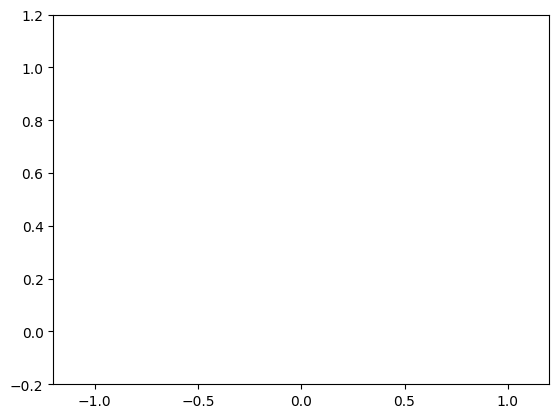

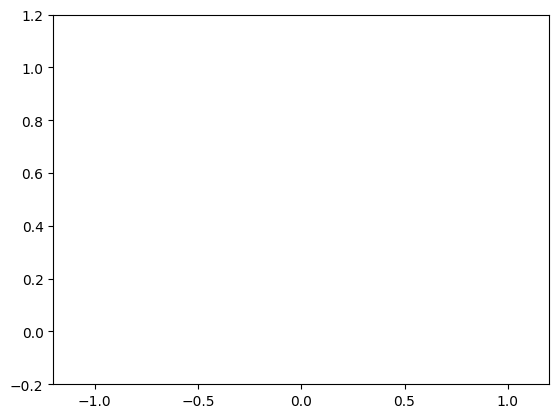

In [362]:
# for _ in range(2):
#     plt.scatter(*zip(*vertex_coordinates.values()))
#     for m, t, c in zip(markers, ts.taxis, colors):
#         plt.scatter(*zip(*[vertex_coordinates[ts.taxis[t].current_vertex]]), marker=m, facecolors='none', edgecolors=c)
#     plt.xlim([-1.2, 1.2])
#     plt.ylim([-0.2, 1.2])
#     plt.show()
#     
#     ts.make_step()

In [373]:
pygame.init()
# Parameters
w_width = 800
w_height = 800
# Set up the drawing window, adjust the size
screen = pygame.display.set_mode([w_width, w_height])

# Set background
screen.fill((255, 255, 255))


def draw(screen, v_cor):
    block_size = 20
    
    for i, j in v_cor.values():
        rect = pygame.Rect(i, j, block_size - 1, block_size - 1)
        pygame.draw.rect(screen, (210, 210, 210), rect, 0)
    pygame.display.flip()
    
draw(screen, v_corr)
    
running = True

time_delay = 200 # 0.2 s
timer_event = pygame.USEREVENT + 1
pygame.time.set_timer(timer_event, time_delay )

while running:
    for event in pygame.event.get():   
        pass
    
pygame.quit()

KeyboardInterrupt: 